In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import sys

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

2024-04-25 11:05:13.659643: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 11:05:13.690122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 11:05:13.690145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 11:05:13.690867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 11:05:13.695616: I tensorflow/core/platform/cpu_feature_guar

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


2024-04-25 11:05:15.545081: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [5]:
NUM_CLASSES = 3
CHANNEL_SIZE = 5
BATCH_SIZE = 32
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [6]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

# Run Experiments

In [7]:
def create_temporal_fixing_experiment(epochs=15, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, first_activation='relu')

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0.0
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        **exp_kwargs
    )

def create_observation_fixing_experiment(epochs=15, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, first_activation=None)

    play_params = {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0.0
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        **exp_kwargs
    )

In [8]:
obs_fixing_experiment = create_observation_fixing_experiment()

In [9]:
obs_fixing_experiment.run()

Running experiment...
Run config:
 {'name': 'experiment', 'max_epochs': 15, 'steps_per_epoch': 50, 'epochs_optimised': 15, 'play_params': {'channel_size': 5, 'p_mutate': 0.0}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': 100, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.009999999776482582, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'complete_loss_fn'}
Epoch 0, Time Taken (mm:ss): 0:10, Mean Loss: 3.847
Test Loss: 4.556, Ground Truth F1-Score: 0.345, Student Error: 1.102, Teacher Error: 0.454, Protocol Diversity: 0.333, Protocol Entropy: 1.6,
Epoch 1, Time Taken (mm:ss): 0:9, Mean Loss: 2.784
Epoch 2, Time Taken (mm:ss): 0:9, Mean Loss: 2.383
Epoch 3, Time Taken (mm:ss): 0:9, Mean Loss: 1.347
Epoch 4, Time Taken (

In [10]:
obs_fixing_experiment.results

{'training_params_results': {'mean_test_loss': 1.0000008344650269,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 3.993511938915617e-07,
  'mean_teacher_error': 5.175920136935019e-07,
  'mean_protocol_diversity': 1.0,
  'mean_protocol_entropy': 7.222249918832856e-35},
 'vanilla_params_results': {'mean_test_loss': 1.0000009536743164,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 3.7431723853842414e-07,
  'mean_teacher_error': 5.168469670024933e-07,
  'mean_protocol_diversity': 1.0,
  'mean_protocol_entropy': 7.222249918832856e-35},
 'student_responsiveness': 0.01779750475426933,
 'teacher_responsiveness': 1.3941823752506407e-05}

In [13]:
temp_fixing_experiment = create_temporal_fixing_experiment()

In [14]:
temp_fixing_experiment.run()

Running experiment...
Run config:
 {'name': 'experiment', 'max_epochs': 15, 'steps_per_epoch': 50, 'epochs_optimised': 15, 'play_params': {'channel_size': 5, 'p_mutate': 0.0}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': 100, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.009999999776482582, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'complete_loss_fn'}
Epoch 0, Time Taken (mm:ss): 0:9, Mean Loss: 3.758
Test Loss: 4.199, Ground Truth F1-Score: 0.351, Student Error: 1.101, Teacher Error: 0.098, Protocol Diversity: 0.333, Protocol Entropy: 1.6,
Epoch 1, Time Taken (mm:ss): 0:9, Mean Loss: 3.832
Epoch 2, Time Taken (mm:ss): 0:9, Mean Loss: 3.777
Epoch 3, Time Taken (mm:ss): 0:9, Mean Loss: 3.762
Epoch 4, Time Taken (m

In [15]:
temp_fixing_experiment.results

{'training_params_results': {'mean_test_loss': 1.005377173423767,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 0.0007417481392621994,
  'mean_teacher_error': 0.0046353391371667385,
  'mean_protocol_diversity': 1.0,
  'mean_protocol_entropy': 7.222249918832856e-35},
 'vanilla_params_results': {'mean_test_loss': 1.0059722661972046,
  'mean_ground_truth_f1': 1.0,
  'ground_truth_acc': 1.0,
  'mean_student_error': 0.0007544516702182591,
  'mean_teacher_error': 0.00521778455004096,
  'mean_protocol_diversity': 1.0,
  'mean_protocol_entropy': 7.222249918832856e-35},
 'student_responsiveness': 0.033126567284397494,
 'teacher_responsiveness': 0.006735518481793149}

In [28]:
games_played, _ = temp_fixing_experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
mean_index_message_map = create_mean_index_message_map(games_played)

In [31]:
mean_class_message_map_df = pd.DataFrame(mean_class_message_map.numpy().T)
mean_index_message_map_df = pd.DataFrame(mean_index_message_map.numpy().T)

In [44]:
from reproducible_figures import (
    save_reproducible_figure, set_plotting_style
)

/tmp/ipykernel_2851/2137728291.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


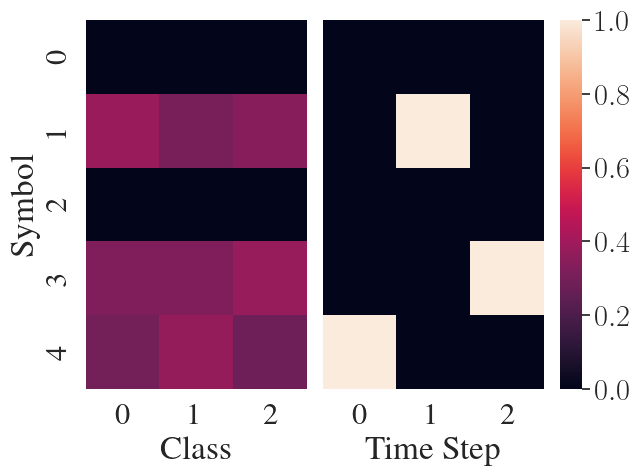

reformatted figures/tf_fixed_protocol_maps/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [62]:
def plot_tf_fixed_protocol_maps(mean_class_message_map_df, mean_index_message_map_df):
    fig, axs = plt.subplots(1, 3,
                            gridspec_kw={'width_ratios': [10, 10, 1], 
                                        'wspace': 0.1}, 
                            sharex='col')

    sns.heatmap(mean_class_message_map_df, vmin=0, vmax=1, ax=axs[0], cbar=False)
    axs[0].set_xlabel('Class')
    axs[0].set_ylabel('Symbol')

    sns.heatmap(mean_index_message_map_df, vmin=0, vmax=1, ax=axs[1], cbar_ax=axs[2])
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('')
    axs[1].set_yticks([])

    plt.tight_layout()


save_reproducible_figure(
    'tf_fixed_protocol_maps',
    (mean_class_message_map_df, mean_index_message_map_df),
    plot_tf_fixed_protocol_maps,
    show=True
)

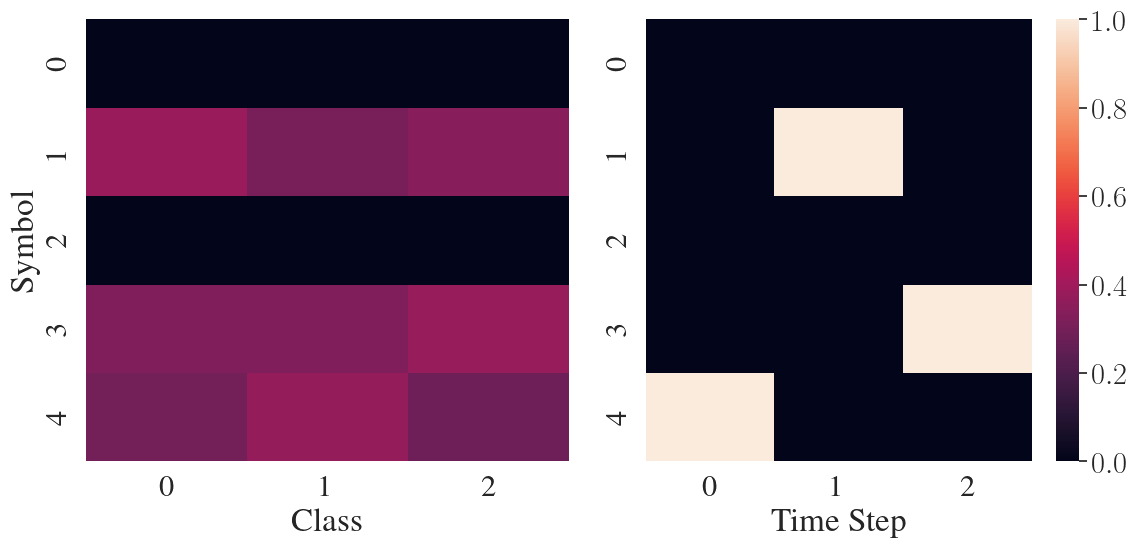

In [47]:
set_plotting_style(font_scale=2)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(mean_class_message_map_df, vmin=0, vmax=1, ax=axs[0])
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Symbol')

sns.heatmap(mean_index_message_map_df, vmin=0, vmax=1, ax=axs[1])
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
games_played, _ = obs_fixing_experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

games_played, _ = obs_fixing_experiment.run_tests()
mean_class_message_map = create_mean_index_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [ ]:
def test_at_different_pms(experiment):
    results = []
    for i in range(6):
        override_play_params = {
            'p_mutate': i / 5.
        }
        _, test_metrics = experiment.run_tests(override_play_params) 
        results.append(test_metrics)
    return results

In [ ]:
pms = [i / 5. for i in range(6)]

In [ ]:
lstm_layer, *_ = [layer for layer in temp_fixing_experiment.student.layers
                  if isinstance(layer, tf.keras.layers.LSTM)]
for w in lstm_layer.weights:
    x = np.abs(w.numpy())
    print(w.name, 'mean:', x.mean(), '+-', x.std(), 'max:', x.max())

In [ ]:
lstm_layer, *_ = [layer for layer in obs_fixing_experiment.student.layers
                  if isinstance(layer, tf.keras.layers.LSTM)]
for w in lstm_layer.weights:
    x = np.abs(w.numpy())
    print(w.name, 'mean:', x.mean(), '+-', x.std(), 'max:', x.max())

In [ ]:
temp_pm_tests = test_at_different_pms(temp_fixing_experiment)

In [ ]:
temp_pm_tests

In [ ]:
obs_pm_tests = test_at_different_pms(obs_fixing_experiment)

In [ ]:
obs_pm_tests

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

metrics = {
    'ground_truth_acc': 'Performance', 
    'mean_student_error': 'Student Error', 
    'mean_teacher_error': 'Teacher Error'
}

for i, metric in enumerate(metrics):

    temp_vals = [
        metrics[metric] for metrics in temp_pm_tests
    ]
    sns.lineplot(x=pms, y=temp_vals, label='Temporally-fixed', ax=axs[i])

    obs_vals = [
        metrics[metric] for metrics in obs_pm_tests
    ]
    sns.lineplot(x=pms, y=obs_vals, label='Observation-fixed', ax=axs[i])

    axs[i].set_xlim([-.05, 1.05])
    axs[i].set_title(f'The Effect of Mutations on {metrics[metric]}')
    axs[i].set_xlabel('Mutation Probability')
    axs[i].set_ylabel(metrics[metric])
    
    if i != 1:
        axs[i].get_legend().remove()

plt.tight_layout()
plt.show()

In [ ]:
games_played, _ = temp_fixing_experiment.run_tests({'p_mutate': 0.8}) 

In [ ]:
for i in range(5):
    inputs, targets, outputs = games_played[i]
    plot_game(inputs, outputs, targets, select_batch=0)

In [ ]:
tf_meta_experiment = MetaExperiment(
    create_experiment_fn=create_temporal_fixing_experiment,
    num_experiments=4,
    epochs=15,
    export_location='./experiments/temporally_fixed',
)

In [ ]:
tf_meta_experiment.run()

In [ ]:
of_meta_experiment = MetaExperiment(
    create_experiment_fn=create_observation_fixing_experiment,
    num_experiments=4,
    epochs=15,
    export_location='./experiments/observation_fixed',
)

In [ ]:
of_meta_experiment.run()

In [ ]:
zs_results = [
    metrics['mean_ground_truth_f1']
    for stranger_pairings in of_meta_experiment.results
    for metrics in stranger_pairings['vanilla_params_test_metrics']
]

print('Final mean zero-shot test performance for OF-agents:', 
      round(float(np.mean(zs_results)), 4), '+-', 
      round(float(np.std(zs_results)), 4))

In [ ]:
zs_results = [
    metrics['mean_ground_truth_f1']
    for stranger_pairings in tf_meta_experiment.results
    for metrics in stranger_pairings['vanilla_params_test_metrics']
]

print('Final mean zero-shot test performance for TF-agents:', 
      round(float(np.mean(zs_results)), 4), '+-', 
      round(float(np.std(zs_results)), 4))